# Functions

In [1]:
%matplotlib inline

import pandas as pd
from pathlib import Path
import os
import shutil
import numpy as np
import math
from IPython.display import clear_output as clear
from sklearn.metrics import confusion_matrix
import seaborn as sns
from fastai.vision.all import *
from fastai.vision.widgets import *
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.utils import shuffle
import shap
from PIL import Image, ImageOps
from shutil import copyfile
from sklearn.metrics import classification_report
from collections import ChainMap

balanced_accuracy = BalancedAccuracy()
recall = Recall()
precision = Precision()

def list_files(dir):
    r = []
    for root, dirs, files in os.walk(dir):
        for name in files:
            r.append(os.path.join(root, name))
    return r

def plot_shap_img(img_path, explainer, learn):
    
    import matplotlib.pyplot as pl
    from shap.plots import colors
    from IPython.display import display

    img = PILImage.create(Path(img_path))
    dl = learn.dls.test_dl([img])
    img_tensor = dl.one_batch()
    pred,pred_iccdx,probs = learn.predict(img)
    shap_values = explainer.shap_values(img_tensor[0])

    for idx, x in enumerate(img_tensor[0]):
        x = x.cpu() # move image to CPU
        label = str(img_path).split('/')[-1] + ': ' + pred + ' | probs: ' + str(round(float(probs[1]), 2)) + '%'
        sv_idx = list(dls.train.vocab).index(pred)

        # plot our explanations
        fig, axes = pl.subplots(ncols = 2, figsize=(10, 10))
        # make sure we have a 2D array for grayscale
        if len(x.shape) == 3 and x.shape[2] == 1:
            x = x.reshape(x.shape[:2])
        if x.max() > 1:
            x /= 255.

        # get a grayscale version of the image
        x_curr_gray = (
            0.2989 * x[0,:,:] +
            0.5870 * x[1,:,:] +
            0.1140 * x[2,:,:]
        )

        x_curr_disp = x

        abs_vals = np.stack(
            [np.abs(shap_values[sv_idx][idx].sum(0))], 0
        ).flatten()
        max_val = np.nanpercentile(abs_vals, 99.9)

        label_kwargs = {'fontsize': 12}
        axes[0].set_title(label, **label_kwargs)

        sv = shap_values[sv_idx][idx].sum(0)
        axes[0].imshow(
            x_curr_gray,
            cmap=pl.get_cmap('gray'),
            alpha=0.5,
            extent=(-1, sv.shape[1], sv.shape[0], -1)
        )
        im = axes[0].imshow(
            sv,
            cmap=colors.red_transparent_blue, 
            vmin=-max_val, 
            vmax=max_val
        )

        axes[0].axis('off')

        fig.tight_layout()


        axes[1].imshow(
            TensorImage(dl.show_batch(show=False)[0][0][0]),
            cmap=pl.get_cmap('gray'),
            alpha=1
        )
        axes[1].axis('off')
        from mpl_toolkits.axes_grid1 import make_axes_locatable

        divider = make_axes_locatable(axes[0])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical')
        return fig
    
def plot_confusion_matrix_by_threshold(display_labels, y_valid, y_pred_proba, threshold = 0.5):
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import confusion_matrix

    y_pred = (y_pred_proba > threshold).astype('float')

    cm = confusion_matrix(y_valid, y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
    disp.plot(cmap = "Blues")
    plt.show()   

def plot_probabilities(y_valid, y_pred_proba, pos_class, dict_classes = {1: 'Scratch', 0: 'No Scratch'}):

    import pandas as pd
    from sklearn import metrics
    import matplotlib.pyplot as plt
    import seaborn as sns

    sns.set()

    precision, recall, thresholds = metrics.precision_recall_curve(y_valid, y_pred_proba, pos_label = pos_class)
    fpr, tpr, thresholds = metrics.roc_curve(y_valid, y_pred_proba, pos_label = pos_class)

    fig, axes = plt.subplots(2,2, figsize=(24,12))

    sns.lineplot(x=fpr, y=tpr, ci=None,ax=axes[0,0])
    axes[0,0].set_title('Receiver Operating Characteristic')
    axes[0,0].set(xlabel='False Positive Rate', ylabel='True Positive Rate')
    axes[0,0].plot([0, 1], [0, 1])

    sns.lineplot(x=recall, y=precision, ci=None, ax=axes[1,0])
    axes[1,0].set_title('Precision Recall Curve')
    axes[1,0].set(xlabel='Recall', ylabel='Precision')

    df = pd.DataFrame({'Actual' : y_valid, 'Probabilities' : y_pred_proba})
    df['Actual'] = df['Actual'].replace(dict_classes)
    sns.histplot(df, bins='scott', x ='Probabilities', hue='Actual', palette = 'bright', stat='probability', legend=True, ax=axes[0,1])
    axes[0,1].set_title('Probabilities')
    axes[0,1].set(xlabel='Score', ylabel='Density')

    sns.histplot(df, bins='scott', x ='Probabilities', y = 'Actual', hue='Actual', palette = 'bright', stat='probability', legend=True, ax=axes[1,1])
    axes[1,1].set_title('Probabilities')
    axes[1,1].set(xlabel='Score', ylabel='Density')
    plt.show()
    
def listdirfull(d, tag = None, drop_Thumbs = True):
    if tag is not None:
         return {os.path.join(d, f): tag for f in os.listdir(d) if f != 'Thumbs.db'}
    return [os.path.join(d, f) for f in os.listdir(d) if f != 'Thumbs.db']

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

# Type Model

In [2]:
IMAGE_PATH_MODEL_402_FAKE = Path('../../opfiles/classification/JPG/555088-402/Fake')
IMAGE_PATH_MODEL_402_REAL = Path('../../opfiles/classification/JPG/555088-402/Real')
IMAGE_PATH_MODEL_105_FAKE = Path('../../opfiles/classification/JPG/555088-105/Fake')
IMAGE_PATH_MODEL_105_REAL = Path('../../opfiles/classification/JPG/555088-105/Fake')

In [3]:
all_path_dict = {IMAGE_PATH_MODEL_402_FAKE: '555088-402', IMAGE_PATH_MODEL_402_REAL: '555088-402', IMAGE_PATH_MODEL_105_FAKE: '555088-105',  IMAGE_PATH_MODEL_105_REAL: '555088-105'}
dict_images = dict(ChainMap(*[listdirfull(path, tag) for path, tag in all_path_dict.items()]))
df = pd.DataFrame(dict_images.items(), columns=['image_name', 'tags'])
df.head()

image_name        tags
0  ../../opfiles/classification/JPG/555088-105/Fake/IMG_9673.jpeg  555088-105
1  ../../opfiles/classification/JPG/555088-105/Fake/IMG_9674.jpeg  555088-105
2  ../../opfiles/classification/JPG/555088-105/Fake/IMG_9675.jpeg  555088-105
3  ../../opfiles/classification/JPG/555088-105/Fake/IMG_9676.jpeg  555088-105
4  ../../opfiles/classification/JPG/555088-105/Fake/IMG_9677.jpeg  555088-105

<AxesSubplot:ylabel='tags'>

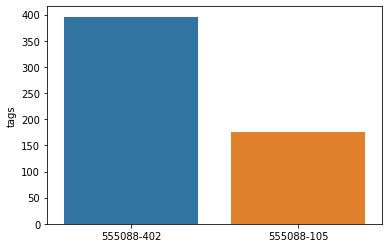

In [5]:
sns.barplot(x=df['tags'].value_counts().index, y=df['tags'].value_counts())

In [7]:
dls = ImageDataLoaders.from_df(df, item_tfms=Resize(128, ResizeMethod.Pad), valid_pct=0.3)

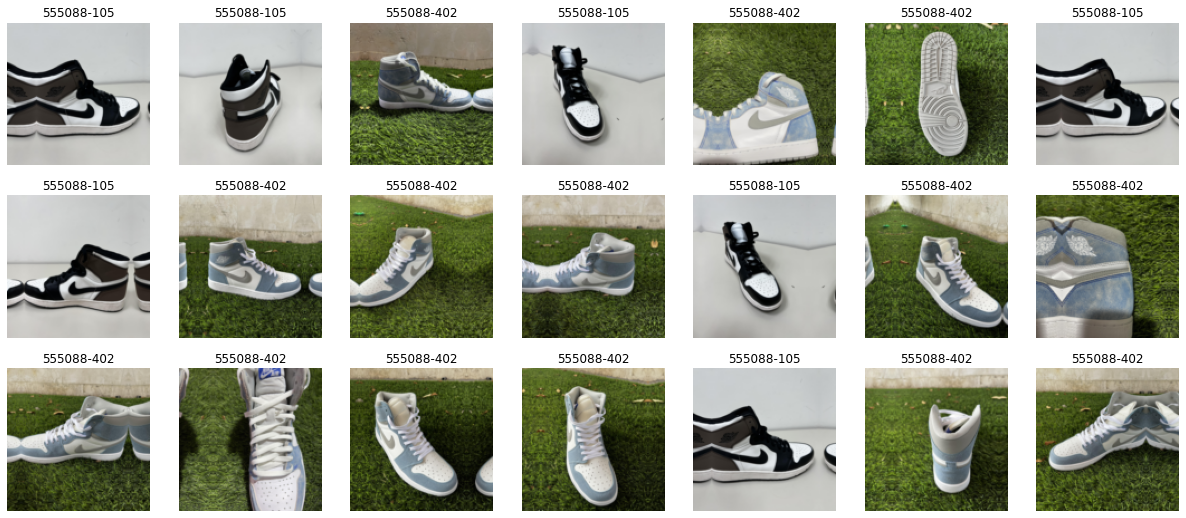

In [8]:
dls.show_batch(max_n=21, nrows=3)

In [9]:
learn = cnn_learner(dls, resnet50, metrics=[error_rate, accuracy, balanced_accuracy, recall, precision])

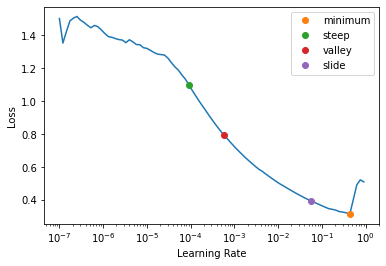

In [10]:
lrs  = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [11]:
learn.fine_tune(10, base_lr=lrs.valley)

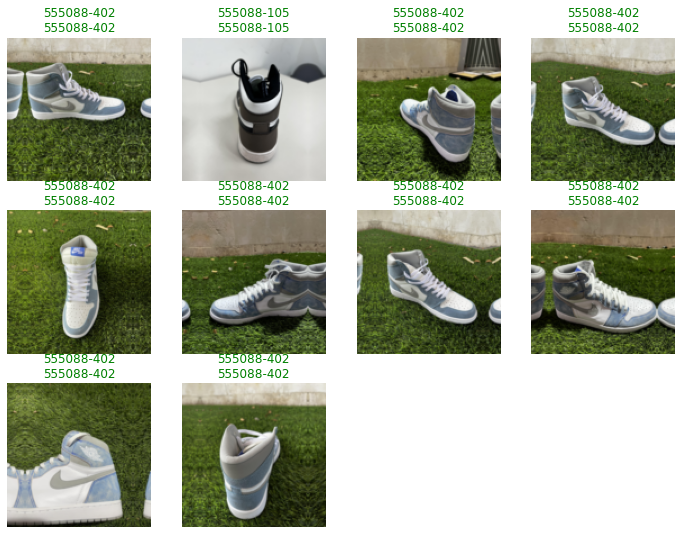

In [12]:
learn.show_results(max_n=10)

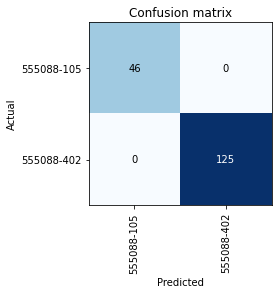

In [13]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [14]:
interp.print_classification_report()

              precision    recall  f1-score   support

  555088-105       1.00      1.00      1.00        46
  555088-402       1.00      1.00      1.00       125

    accuracy                           1.00       171
   macro avg       1.00      1.00      1.00       171
weighted avg       1.00      1.00      1.00       171



In [15]:
learn.export('model_type_shoe.pkl')

# Modeling 555088-402

In [ ]:
IMAGE_PATH_MODEL_402 = Path('../../opfiles/classification/JPG/555088-402')

In [23]:
data = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    get_y=parent_label,
    item_tfms=Resize(128, ResizeMethod.Pad),
    batch_tfms=aug_transforms(size=128))

In [9]:
dls = data.dataloaders(IMAGE_PATH_MODEL_402)

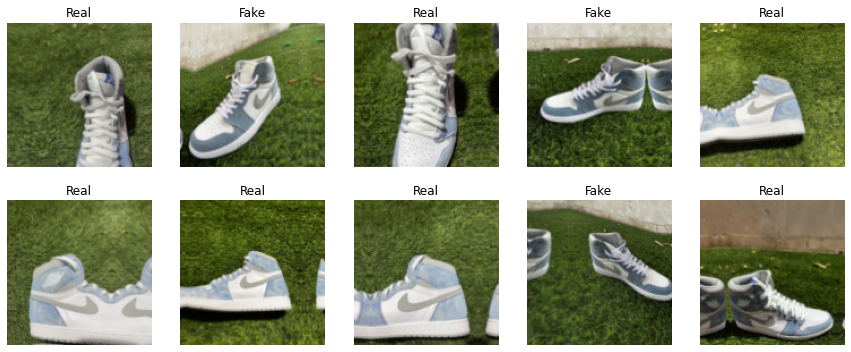

In [10]:
dls.train.show_batch(max_n=10, nrows=2)

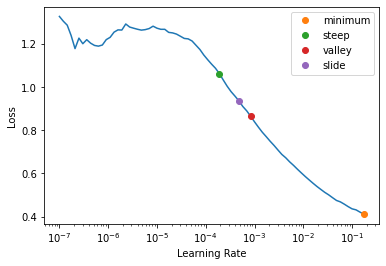

In [11]:
learn = cnn_learner(dls, resnet50, metrics=[error_rate, accuracy, balanced_accuracy, recall, precision])

lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [12]:
learn.fine_tune(10, base_lr=lrs.valley)

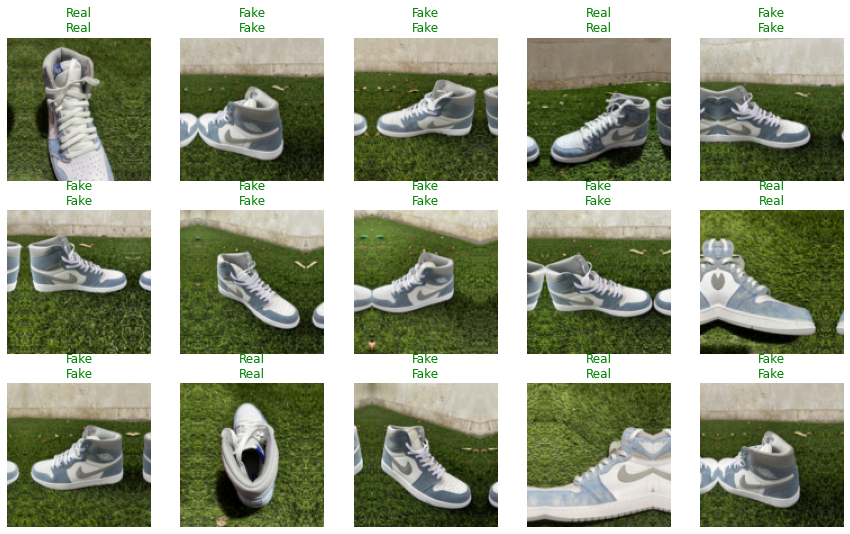

In [13]:
learn.show_results(max_n=15)

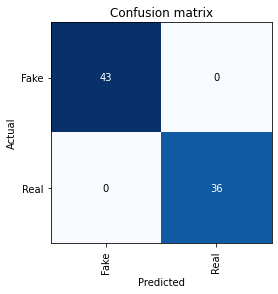

In [14]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [15]:
interp.print_classification_report()

              precision    recall  f1-score   support

        Fake       1.00      1.00      1.00        43
        Real       1.00      1.00      1.00        36

    accuracy                           1.00        79
   macro avg       1.00      1.00      1.00        79
weighted avg       1.00      1.00      1.00        79



In [17]:
# pull a sample of our data (128 images)
batch = dls.one_batch()

# specify how many images to use when creating the background distribution
explainer = shap.GradientExplainer(
    learn.model, batch[0]
)

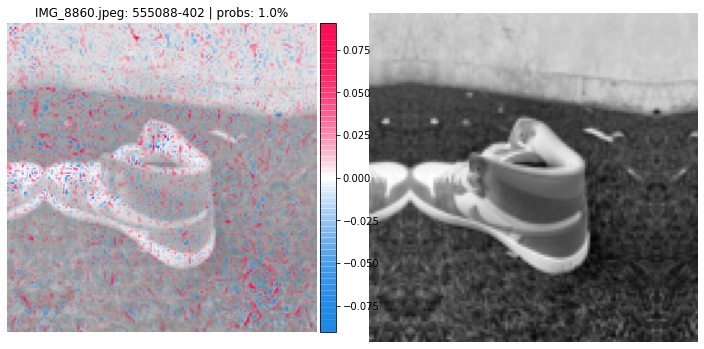

In [18]:
#x = plot_shap_img(Path('../../opfiles/project/test/1')/df_result.iloc[50]['image_name'], explainer, learn)
x = plot_shap_img(Path('../../opfiles/classification/JPG/555088-402/Fake/IMG_8860.jpeg'), explainer, learn)

In [20]:
learn.export('model_fake_real_555088-402.pkl')

# Modeling 555088-105

In [19]:
IMAGE_PATH_MODEL_105 = Path('../../opfiles/classification/JPG/555088-105')

In [3]:
data = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    get_y=parent_label,
    item_tfms=Resize(128, ResizeMethod.Pad),
    batch_tfms=aug_transforms(size=128))

In [4]:
dls = data.dataloaders(IMAGE_PATH_MODEL_105)

In [5]:
dls.train_ds

(#308) [(PILImage mode=RGB size=3024x4032, TensorCategory(0)),(PILImage mode=RGB size=3024x4032, TensorCategory(1)),(PILImage mode=RGB size=3024x4032, TensorCategory(1)),(PILImage mode=RGB size=3024x4032, TensorCategory(1)),(PILImage mode=RGB size=3024x4032, TensorCategory(0)),(PILImage mode=RGB size=3024x4032, TensorCategory(0)),(PILImage mode=RGB size=4032x3024, TensorCategory(1)),(PILImage mode=RGB size=3024x4032, TensorCategory(1)),(PILImage mode=RGB size=3024x4032, TensorCategory(1)),(PILImage mode=RGB size=3024x4032, TensorCategory(1))...]

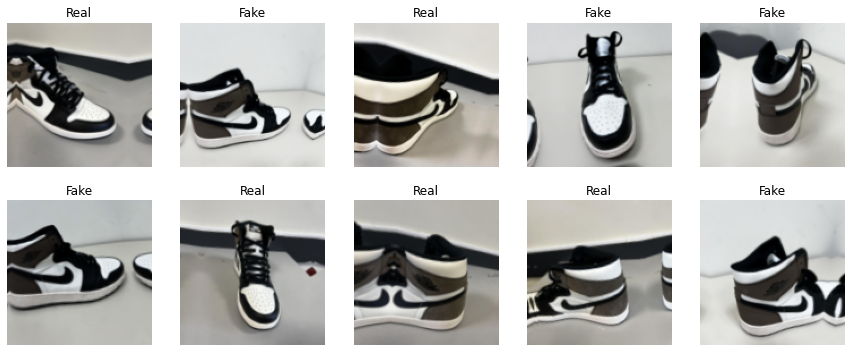

In [6]:
dls.train.show_batch(max_n=10, nrows=2)

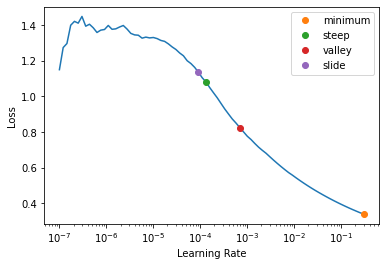

In [7]:
learn = cnn_learner(dls, resnet50, metrics=[error_rate, accuracy, balanced_accuracy, recall, precision])

lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [8]:
learn.fine_tune(10, base_lr=lrs.valley)

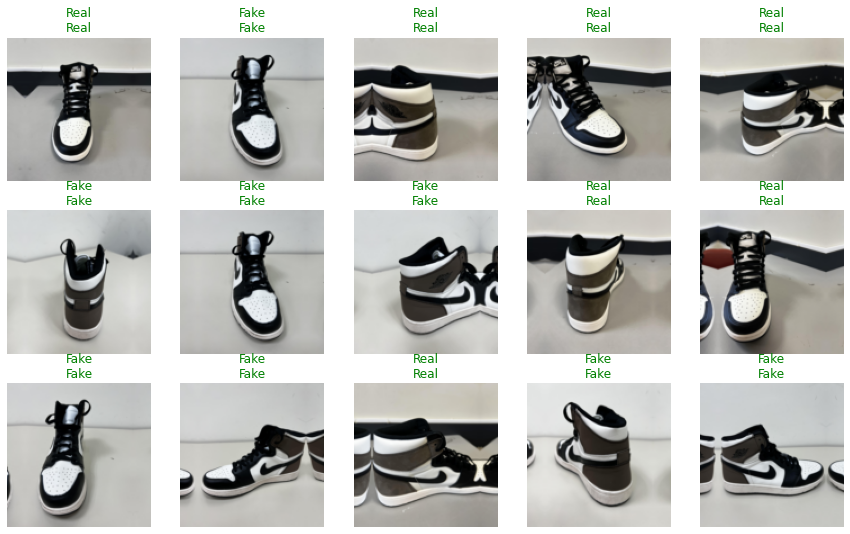

In [9]:
learn.show_results(max_n=15)

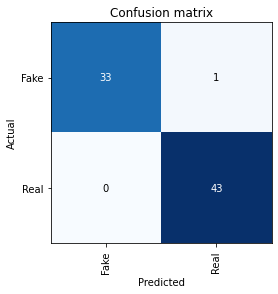

In [10]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [11]:
interp.print_classification_report()

              precision    recall  f1-score   support

        Fake       1.00      0.97      0.99        34
        Real       0.98      1.00      0.99        43

    accuracy                           0.99        77
   macro avg       0.99      0.99      0.99        77
weighted avg       0.99      0.99      0.99        77



In [12]:
# pull a sample of our data (128 images)
batch = dls.one_batch()

# specify how many images to use when creating the background distribution
explainer = shap.GradientExplainer(
    learn.model, batch[0]
)

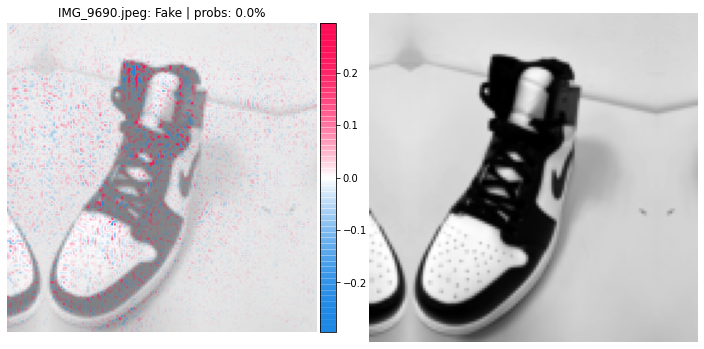

In [16]:
#x = plot_shap_img(Path('../../opfiles/project/test/1')/df_result.iloc[50]['image_name'], explainer, learn)
x = plot_shap_img(Path('../../opfiles/classification/JPG/555088-105/Fake/IMG_9690.jpeg'), explainer, learn)

In [17]:
learn.export('model_fake_real_555088-105.pkl')